The idea here is to take the reference homozygous calls (much like in the TRD analyses) and compare 
1) how well they overlap with the het calls of the cross
2) if they overlap better with any other (use a combination matrix of all strains that I crossed)

In [1]:
source("~/BrusselSprouts/scripts/functions.R")
cross_positions_ad_gr0=fread("~/data/trd/mapped_reads/YJNRC2.vcf.gz.ADgr0.txt.gz")
OHLoci_GT=fread("~/data/TRD/Oppo-Homo-Pos/YJNRC2.ohloci.GT.gz")


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
SameAllele=function(x){
    # bcftools does not let me compare GTs between samples, so here I am finding the few instances where my loci filter does not work (when both are 2/2 I think)
    a1=substr(OHLoci_GT$V6[x],1,1)
    a2=substr(OHLoci_GT$V7[x],1,1)
    
    return(a1==a2)
}
getDP=function(x){
    DP_pos=which(strsplit(OHLoci_GT$V5[x],":",fixed=TRUE)[[1]]=="DP")
    DP1=as.numeric(strsplit(OHLoci_GT$V6[x],":",fixed=TRUE)[[1]][DP_pos])
    DP2=as.numeric(strsplit(OHLoci_GT$V7[x],":",fixed=TRUE)[[1]][DP_pos])
    return(data.frame(DP1=DP1,DP2=DP2))
}

In [5]:
OHLoci_GT=OHLoci_GT[!unlist(lapply(1:nrow(OHLoci_GT), SameAllele)),]
OHLoci_GT=bind_cols(OHLoci_GT, bind_rows(lapply(1:nrow(OHLoci_GT), getDP)))
nrow(OHLoci_GT)

[1] 55954

In [6]:
getDP=function(x){
    DP_pos=which(strsplit(cross_positions_ad_gr0$V5[x],":",fixed=TRUE)[[1]]=="DP")
    DP=as.numeric(strsplit(cross_positions_ad_gr0$V6[x],":",fixed=TRUE)[[1]][DP_pos])
    return(data.frame(DP=DP))
}

In [7]:
cross_positions_ad_gr0=bind_cols(cross_positions_ad_gr0, bind_rows(lapply(1:nrow(cross_positions_ad_gr0), getDP)))

In [8]:
head(cross_positions_ad_gr0)

,V1,V2,V3,V4,V5,V6,DP
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,chromosome1,529,C,A,GT:PL:DP:AD,"0/1:34,0,111:4:3,1",4
2,chromosome1,573,G,C,GT:PL:DP:AD,"0/1:51,0,88:3:2,1",3
3,chromosome1,579,T,C,GT:PL:DP:AD,"0/1:37,0,100:3:2,1",3
4,chromosome1,986,A,G,GT:PL:DP:AD,"0/1:81,0,25:3:1,2",3
5,chromosome1,990,G,C,GT:PL:DP:AD,"0/1:54,0,28:2:1,1",2
6,chromosome1,1199,G,T,GT:PL:DP:AD,"0/1:42,0,140:7:5,2",7


In [9]:
summarise(group_by(cross_positions_ad_gr0, grepl(",",V4,fixed=TRUE), paste(V1,V2)%in%paste(OHLoci_GT$V1,OHLoci_GT$V2)), n=n())

`summarise()` has grouped output by 'grepl(",", V4, fixed = TRUE)'. You can override using the `.groups` argument.


"grepl("","", V4, fixed = TRUE)","paste(V1, V2) %in% paste(OHLoci_GT$V1, OHLoci_GT$V2)",n
<lgl>,<lgl>,<int>
FALSE,FALSE,66033
FALSE,TRUE,29471
TRUE,FALSE,8
TRUE,TRUE,10


In [10]:
summary(cross_positions_ad_gr0$DP)
summary(OHLoci_GT$DP1)
summary(OHLoci_GT$DP2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2       7      10      10      12     226 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0   209.0   231.0   229.8   252.0  4731.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0   274.0   315.0   316.7   359.0  4878.0 

In [11]:
summary(paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2)%in%paste(OHLoci_GT$V1,OHLoci_GT$V2))
summary(paste(OHLoci_GT$V1,OHLoci_GT$V2)%in%paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2))

   Mode   FALSE    TRUE 
logical   66041   29481 

   Mode   FALSE    TRUE 
logical   26473   29481 

In [12]:
cross_positions_ad_gr0_DPfilter=subset(cross_positions_ad_gr0, DP>=quantile(cross_positions_ad_gr0$DP,0.05)&
                                                      DP<=quantile(cross_positions_ad_gr0$DP,0.95))
OHLoci_GT_DPfilter=subset(OHLoci_GT, DP1>=quantile(OHLoci_GT$DP1,0.05)&
                                                      DP1<=quantile(OHLoci_GT$DP1,0.95) & 
                         DP2>=quantile(OHLoci_GT$DP2,0.05)&
                                                      DP2<=quantile(OHLoci_GT$DP2,0.95))

In [13]:
summary(paste(cross_positions_ad_gr0_DPfilter$V1,cross_positions_ad_gr0_DPfilter$V2)%in%paste(OHLoci_GT_DPfilter$V1,OHLoci_GT_DPfilter$V2))
summary(paste(OHLoci_GT_DPfilter$V1,OHLoci_GT_DPfilter$V2)%in%paste(cross_positions_ad_gr0_DPfilter$V1,cross_positions_ad_gr0_DPfilter$V2))

   Mode   FALSE    TRUE 
logical   64209   23954 

   Mode   FALSE    TRUE 
logical   22446   23954 

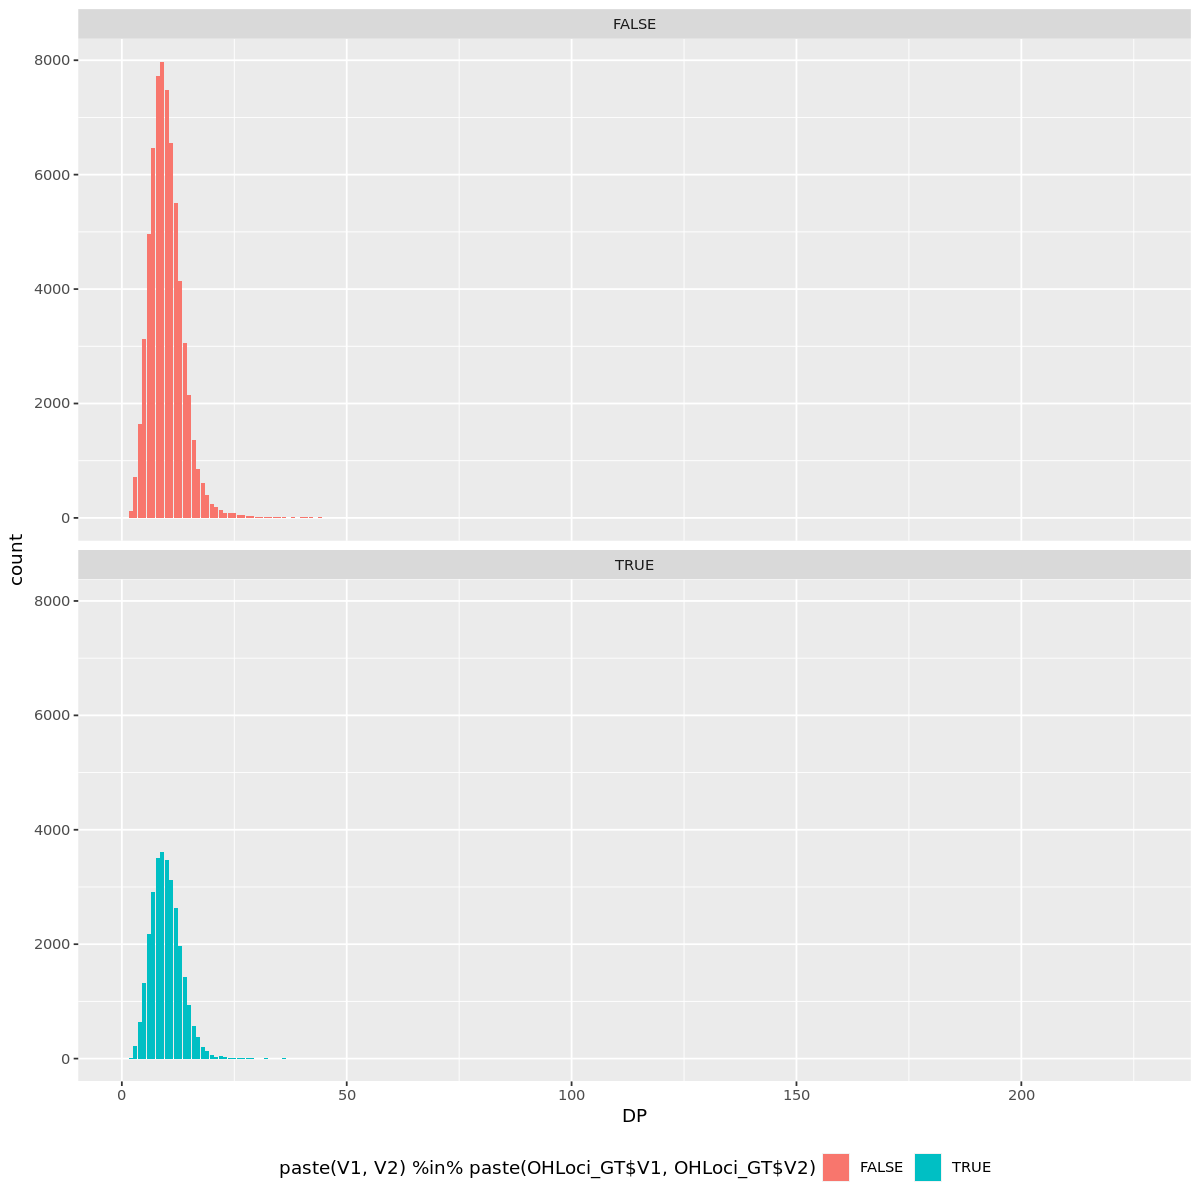

In [14]:
library(ggplot2)
ggplot(cross_positions_ad_gr0, aes(DP,fill=paste(V1,V2)%in%paste(OHLoci_GT$V1,OHLoci_GT$V2)))+
geom_bar(position="dodge")+theme(legend.position="bottom")+facet_wrap(~paste(V1,V2)%in%paste(OHLoci_GT$V1,OHLoci_GT$V2), ncol=1)

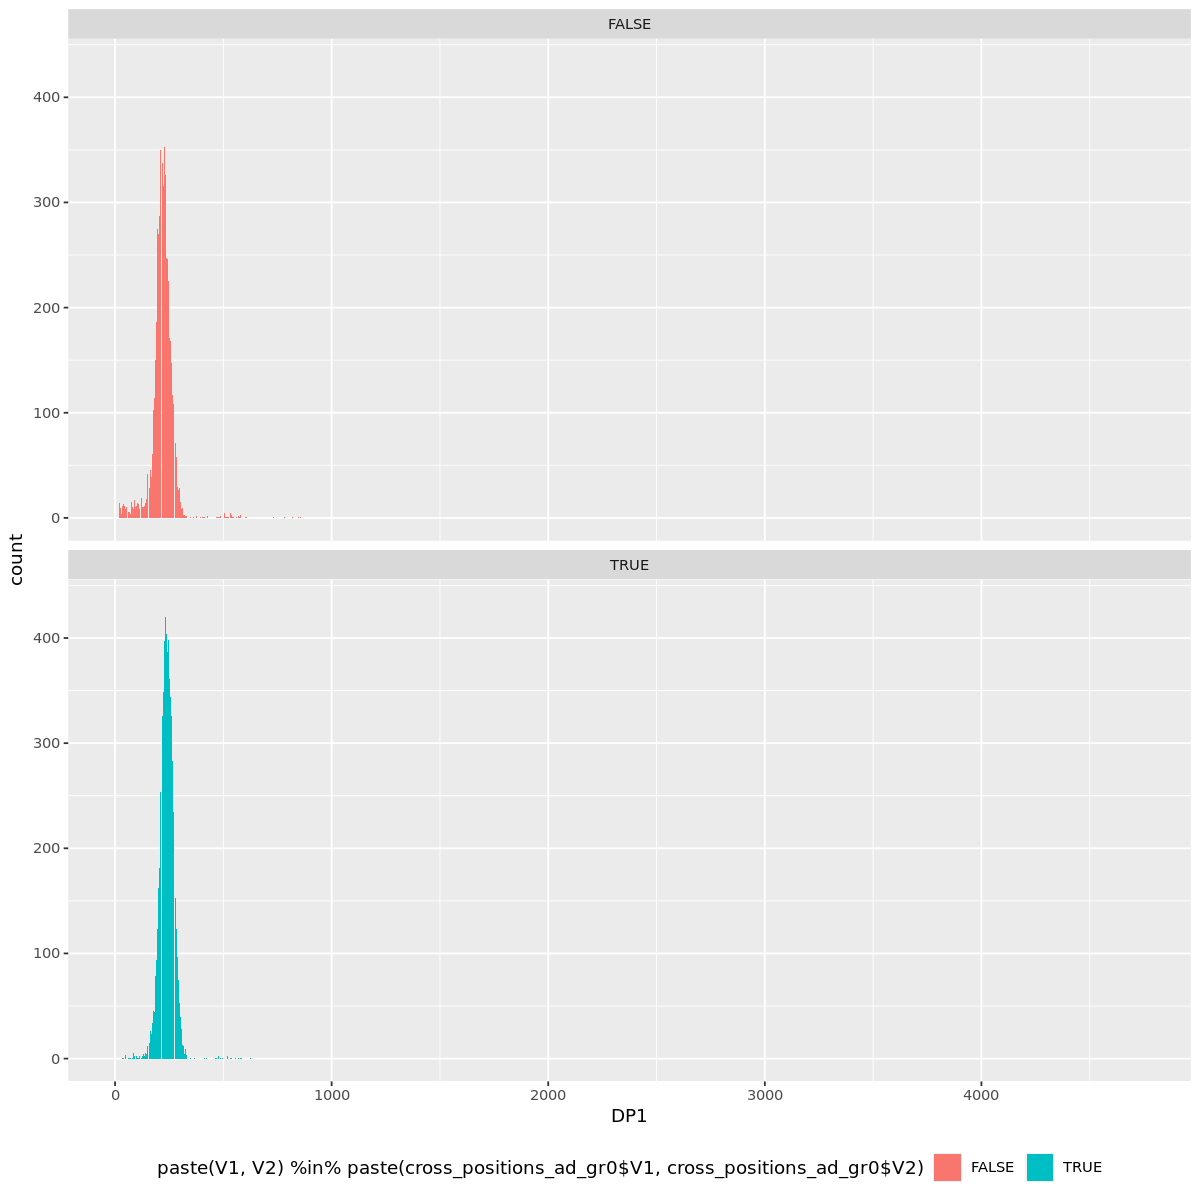

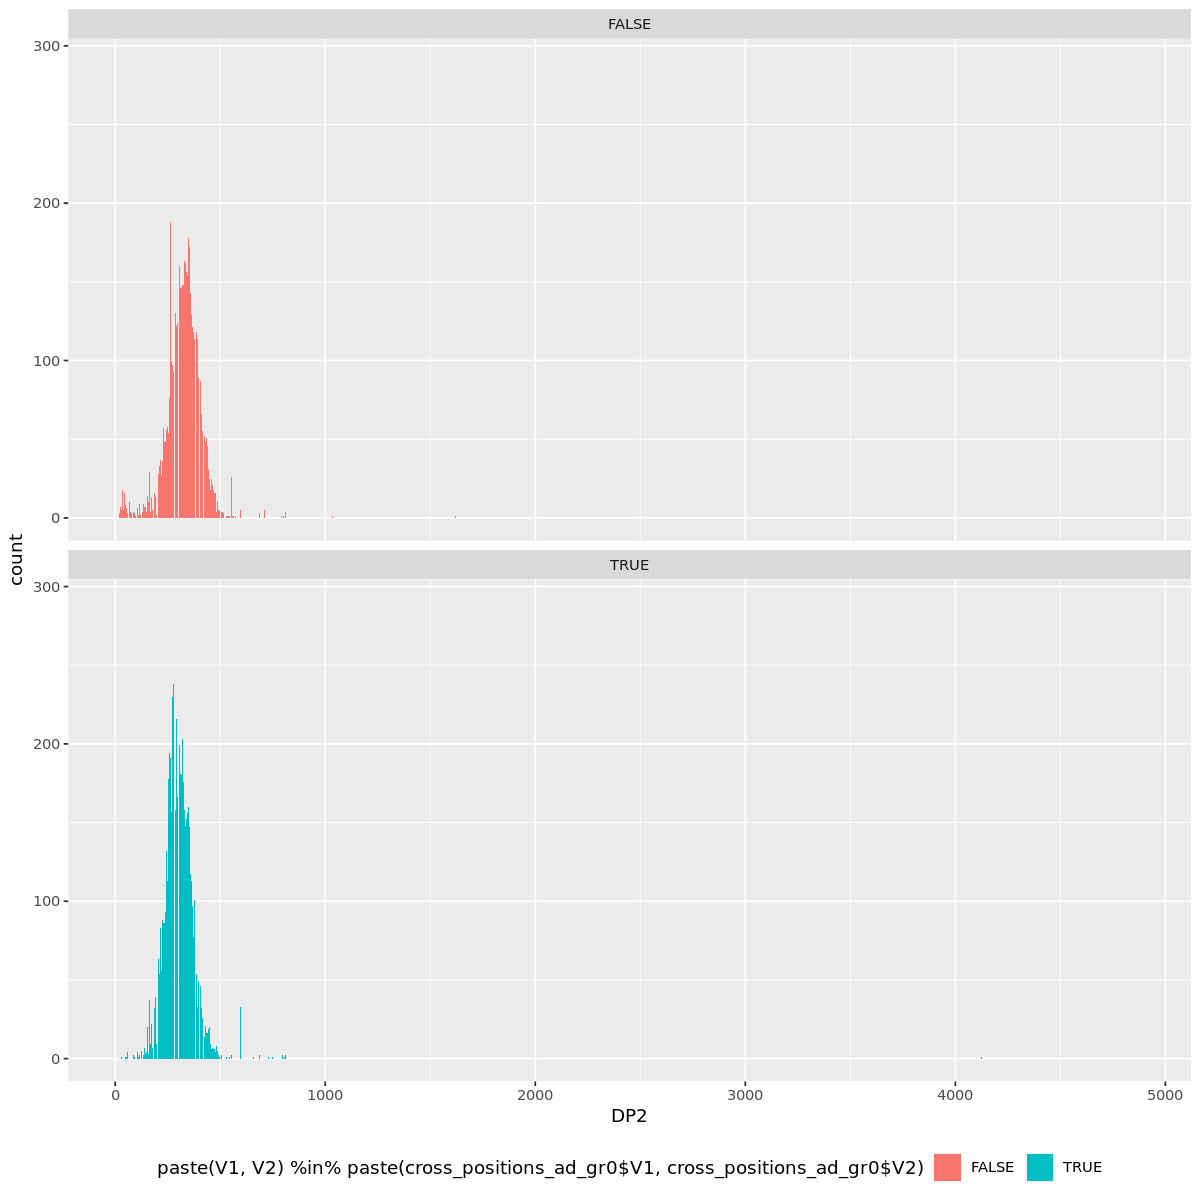

In [15]:
ggplot(OHLoci_GT, aes(DP1,fill=paste(V1,V2)%in%paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2)))+
geom_bar(position="dodge")+theme(legend.position="bottom")+facet_wrap(~paste(V1,V2)%in%paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2), ncol=1)
ggplot(OHLoci_GT, aes(DP2,fill=paste(V1,V2)%in%paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2)))+
geom_bar(position="dodge")+theme(legend.position="bottom")+facet_wrap(~paste(V1,V2)%in%paste(cross_positions_ad_gr0$V1,cross_positions_ad_gr0$V2), ncol=1)